In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path


import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
import os
# from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [3]:
np.random.seed(31101995)
torch.manual_seed(31101995)

In [4]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

# Load data using "csv" and clean

In [33]:
csv_path = '/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/meta_data_survival_mapping.csv'
all_data = pd.read_csv(csv_path)
all_data = all_data[all_data.label_flair != 'discard']
all_data = all_data[all_data.label_t1 != 'discard']
all_data = all_data[all_data.label_t1ce != 'discard']
all_data = all_data[all_data.label_t2 != 'discard']
# # all_data = all_data.reset_index(drop =True)
# # shuffle the DataFrame
all_data_df = all_data.sample(frac=1, random_state=42000)
all_data_df = all_data_df.reset_index(drop =True)
all_data_df.head()
# all_data.head()

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_149,BraTS20_Training_149_seg_139,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,NaN,NaN,NaN,NaN
1,BraTS20_Training_233,BraTS20_Training_233_seg_80,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_233,46.953,333,NaN
2,BraTS20_Training_064,BraTS20_Training_064_seg_125,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_064,70.252,12,GTR
3,BraTS20_Training_343,BraTS20_Training_343_seg_16,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,NaN,NaN,NaN,NaN
4,BraTS20_Training_254,BraTS20_Training_254_seg_65,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_254,66.479,147,NaN


In [196]:
sample_df = all_data_df.sample(n=300, random_state=42)
sample_df = sample_df.reset_index(drop =True)
sample_df['label_flair'].value_counts()

healthy    162
HGG        111
LGG         26
Name: label_flair, dtype: int64

In [197]:
f = dict(sample_df.label_flair.value_counts())
t1 = sample_df.label_t1.value_counts().to_dict()
t1ce = sample_df.label_t1ce.value_counts().to_dict()
t2 = sample_df.label_t2.value_counts().to_dict()
print('flair:', f)
print('t1:',t1)
print('t1ce:',t1ce)
print('t2:',t2)

flair: {'healthy': 162, 'HGG': 111, 'LGG': 26}
t1: {'healthy': 163, 'HGG': 111, 'LGG': 26}
t1ce: {'healthy': 163, 'HGG': 111, 'LGG': 26}
t2: {'healthy': 163, 'HGG': 111, 'LGG': 26}


# Load train, val and test df

In [36]:
def preprocess_metadata_csv(csv_path):
    """Load meta csv. Filter samples to be discarded."""
    meta_data = pd.read_csv(csv_path)
    meta_data = meta_data[meta_data.label_flair != 'discard']
    meta_data = meta_data[meta_data.label_t1 != 'discard']
    meta_data = meta_data[meta_data.label_t1ce != 'discard']
    meta_data = meta_data[meta_data.label_t2 != 'discard']
    meta_data_df  = meta_data.reset_index(drop =True)
    return meta_data_df


dataframe_dir = 'home/shsingh/knowledge_distillation/dataset/scratch/dataframes'

# train_df = pd.read_csv(dataframe_dir / 'train_df.csv')
# val_df = pd.read_csv(dataframe_dir / 'val_df.csv')
# test_df = pd.read_csv(dataframe_dir / 'test_df.csv')
def get_splits(dataframe_dir):
    train_df = pd.read_csv(dataframe_dir / 'train_df.csv')
    val_df = pd.read_csv(dataframe_dir / 'val_df.csv')
    test_df = pd.read_csv(dataframe_dir / 'test_df.csv')
    return train_df, val_df, test_df

def get_data_from_csv(csv_path, dataframe_dir):    
    if  not dataframe_dir:
        train_df, val_df, test_df = get_splits(dataframe_dir) 
    else:
        meta_data_df = preprocess_metadata_csv(csv_path)
        test_split = 0.4
        val_split = 0.1
        train_df, test_df, val_df = split_dataset(all_data_df, test_split, val_split)    
    return train_df, val_df, test_df




In [198]:
def get_data_df(csv_path):
    data_df = pd.read_csv(csv_path)
    data_df = data_df[data_df.label_flair != 'discard']
    data_df = data_df.reset_index(drop =True)
    return data_df

# Prevent data lekage: splits must not have patches from same subject

>## Split df: train_df, val_df, test_df

In [10]:
# all_data.shape
sample_df.shape

(300, 11)

In [6]:
all_data.shape

(50899, 11)

In [7]:
def split_dataset(data, test_split, val_split):
    test_size = test_split + val_split
    val_size = 0.1/test_size 
#     print("test_size:", test_size, "val_size:", val_size)
    subject_list = np.unique(data.subject_id).tolist()
    
    training_subjects, test_subjects = train_test_split(subject_list ,
                                                        test_size = test_size, 
                                                        random_state = 42000,
                                                        shuffle = True)
    test_subject, val_subjects = train_test_split(test_subjects ,
                                                  test_size = val_size, 
                                                  random_state = 42000,
                                                  shuffle = True)
    print('{:.2f}'.format(len(training_subjects)/len(subject_list)),
          '{:.2f}'.format(len(test_subject)/len(subject_list)),
          '{:.2f}'.format(len(val_subjects)/len(subject_list)))
    print(len(training_subjects), len(test_subject), len(val_subjects))
    
    train_df = data[data['subject_id'].isin(training_subjects)].reset_index(drop=True)
    test_df = data[data['subject_id'].isin(test_subject)].reset_index(drop=True)
    val_df = data[data['subject_id'].isin(val_subjects)].reset_index(drop=True)
    return train_df, test_df, val_df
    

In [8]:
test_split = 0.4
val_split = 0.1
# training_subjects, test_subject, val_subjects = split_dataset(all_data, test_split, val_split)

In [9]:
# train_df, test_df, val_df = split_dataset(all_data, test_split, val_split)
train_df, test_df, val_df = split_dataset(all_data_df, test_split, val_split)

0.50 0.40 0.10
184 148 37


In [10]:
train_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_149,BraTS20_Training_149_seg_139,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,NaN,NaN,NaN,NaN
1,BraTS20_Training_343,BraTS20_Training_343_seg_16,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,NaN,NaN,NaN,NaN
2,BraTS20_Training_008,BraTS20_Training_008_seg_84,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_008,68.285,1278,NaN
3,BraTS20_Training_348,BraTS20_Training_348_seg_46,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_348,59.000,759,STR
4,BraTS20_Training_354,BraTS20_Training_354_seg_108,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_354,64.000,311,STR
...,...,...,...,...,...,...,...,...,...,...,...
25489,BraTS20_Training_293,BraTS20_Training_293_seg_78,/home/shsingh/knowledge_distillation/dataset/s...,LGG,LGG,LGG,LGG,NaN,NaN,NaN,NaN
25490,BraTS20_Training_062,BraTS20_Training_062_seg_121,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_062,68.504,376,GTR
25491,BraTS20_Training_325,BraTS20_Training_325_seg_48,/home/shsingh/knowledge_distillation/dataset/s...,LGG,LGG,LGG,LGG,NaN,NaN,NaN,NaN
25492,BraTS20_Training_122,BraTS20_Training_122_seg_41,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_122,69.003,336,GTR


In [10]:
def get_distribution_ratio(split_dict):    
    total = sum(split_dict.values())
    result = {key: '{:.2f}'.format(value / total) for key, value in split_dict.items()}
    print(result)
    return result

def get_class_distribution(train_df, test_df, val_df, mod):
    label_col = f'label_{mod}'
    train_dict = train_df[label_col].value_counts().to_dict()
    val_dict = val_df[label_col].value_counts().to_dict()
    test_dict = test_df[label_col].value_counts().to_dict()
    index_labels=['train','val','test']
    class_distribution_df = pd.DataFrame([train_dict, val_dict,test_dict], 
                                                   index=index_labels,
                                                  )
    class_distribution_ratio_df = pd.DataFrame([get_distribution_ratio(train_dict), 
                                                 get_distribution_ratio(val_dict),
                                                 get_distribution_ratio(test_dict)], 
                                                     index=index_labels,
                                                    )
#     class_distribution_ratio_df = pd.DataFrame.from_dict([get_distribution_ratio(train_dict), 
#                                                      get_distribution_ratio(val_dict),
#                                                      get_distribution_ratio(test_dict)], 
#                                                          index=index_labels,
#                                                         )
    
    return class_distribution_df, class_distribution_ratio_df
        

In [11]:
class_distribution_df, class_distribution_ratio_df = get_class_distribution(train_df, test_df, val_df, 't1')

{'healthy': '0.52', 'HGG': '0.39', 'LGG': '0.09'}
{'healthy': '0.52', 'HGG': '0.37', 'LGG': '0.11'}
{'healthy': '0.52', 'HGG': '0.38', 'LGG': '0.10'}


In [12]:
class_distribution_df

,healthy,HGG,LGG
train,13242,9905,2320
val,2636,1852,576
test,10644,7724,1948


In [206]:
class_distribution_ratio_df

,healthy,HGG,LGG
train,0.52,0.39,0.09
val,0.52,0.37,0.11
test,0.52,0.38,0.10


In [207]:
train_dist =  train_df.label_t1.value_counts().to_dict()
val_dist = val_df.label_t1.value_counts().to_dict()
test_dist = test_df.label_t1.value_counts().to_dict()
print(train_dist)
print(val_dist)
print(test_dist)


{'healthy': 13242, 'HGG': 9905, 'LGG': 2320}
{'healthy': 2636, 'HGG': 1852, 'LGG': 576}
{'healthy': 10644, 'HGG': 7724, 'LGG': 1948}


In [208]:
total = sum(train_dist.values())
result = {key: value / total for key, value in train_dist.items()}
print(result)

{'healthy': 0.5199670161385322, 'HGG': 0.38893469980759415, 'LGG': 0.09109828405387364}


In [209]:
total_val = sum(val_dist.values())
result_val = {key: value / total_val for key, value in val_dist.items()}
print(result_val)

{'healthy': 0.5205371248025277, 'HGG': 0.3657187993680885, 'LGG': 0.11374407582938388}


In [210]:
total_test = sum(test_dist.values())
result_test = {key: value / total_test for key, value in test_dist.items()}
print(result_test)

{'healthy': 0.5239220318960425, 'HGG': 0.3801929513683796, 'LGG': 0.09588501673557787}


# CustomDataLoader

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image

def class_to_idx(label):
    idx = 0
    if label == 'healthy':idx =0
    if label == 'HGG':idx =1
    if label=='LGG': idx = 2        
    return idx

class CustomImageDataset_from_csv(Dataset):
    def __init__(self, data_df , mod, transform = None , label_transform= None):
        self.dataframe = data_df #pd.read_csv(annotations_file)
        self.mod = mod
        self.transform = transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.dataframe)
    
#     def __getitem__(self , idx):
#         img_path =  self.dataframe.loc[idx,'image_path'] 
#         image = np.load(img_path)
#         grayscale_image = np.resize(img, (224,224))
#         image = np.repeat(grayscale_image[..., np.newaxis], 3, -1)
#         print('dtype:', image.dtype)
#         image = image.astype('float32')
#         print('AFTER dtype:', image.dtype)
#         label_col = 'label_' + str(self.mod)     
#         label = self.dataframe.loc[idx, label_col]
#         label = class_to_idx(label)
#         label = torch.tensor([label])
                             
#         if self.transform is not None:
#             image = self.transform(image)
#         if self.label_transform:
#             label = self.target_transform(label)
#         return(image, label )
    
    def __getitem__(self , idx):
        img_path =  self.dataframe.loc[idx,'image_path'] 
        img = np.load(img_path)
        grayscale_image = np.resize(img, (224,224))
        image = np.repeat(grayscale_image[..., np.newaxis], 3, -1)
        image = image.astype('float32')
        label_col = 'label_' + str(self.mod)     
        label_mod = self.dataframe.loc[idx, label_col]
        class_label = class_to_idx(label_mod)
        label = torch.tensor([class_label])
                             
        if self.transform is not None:
            image = self.transform(image)
        if self.label_transform:
            label = self.target_transform(label)
        return(image, label )
########################################################################


In [18]:
def get_CustomImageDataset_from_csv(df, mod):
    data = CustomImageDataset_from_csv(df , mod,
           transform=transforms.Compose([
#                transforms.RandomHorizontalFlip(p=0.5),
#                                          transforms.RandomRotation(15),
                                         transforms.ToTensor(),                                          
#                                          transforms.Normalize(mean=[0.0355, 0.0164, 0.0047], std=[0.2799, 0.1805, 0.1009]),
                                        ]))
    return data

In [19]:


def get_dataloader(train_df, test_df, val_df, mod, batch_size):
    np.random.seed(31101995)
    torch.manual_seed(31101995)
    train_data = get_CustomImageDataset_from_csv(train_df, mod)                                                   
    test_data =get_CustomImageDataset_from_csv(test_df, mod)                                              
    val_data = get_CustomImageDataset_from_csv(val_df, mod)                                            
    
    train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
    val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
    test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)
    return  train_dataloader, val_dataloader, test_dataloader


# t1

In [20]:
batch_size = 64
mod = 't1'
train_dataloader, val_dataloader, test_dataloader =  get_dataloader(train_df, test_df, val_df ,mod ,batch_size )

In [21]:
for images, labels in train_dataloader:
    print(labels)
    break

tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [1],
        [2],
        [1],
        [0],
        [2],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [2],
        [0],
        [2],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1]])


In [19]:
# np.random.seed(31101995)
# torch.manual_seed(31101995)

images_li =[]
for images_t1,_ in train_dataloader:
    train_mean = images_t1.reshape(3,-1).mean(axis=1)
    train_std = images_t1.reshape(3,-1).std(axis=1)
    images_li.append(images_t1)
    
print(train_mean, train_std) 
print(len(images_li[0]))
# transforms.Normalize(mean = train_mean ,std = train_std)

tensor([0.0214, 0.0228, 0.0341]) tensor([0.2257, 0.2486, 0.2636])
64


# t1ce

In [20]:
# np.random.seed(31101995)
# torch.manual_seed(31101995)

batch_size = 64
mod = 't1ce'
train_t1ce, val_t1ce, test_t1ce =  get_dataloader(train_df, test_df, val_df ,mod ,batch_size )
images_t1ce_li =[]
for images_t1ce,_ in train_t1ce:
    train_mean_t1ce = images_t1ce.reshape(3,-1).mean(axis=1)
    train_std_t1ce = images_t1ce.reshape(3,-1).std(axis=1)
    images_t1ce_li.append(images_t1ce)
    
print(train_mean_t1ce, train_std_t1ce)

tensor([0.0214, 0.0228, 0.0341]) tensor([0.2257, 0.2486, 0.2636])


# flair

In [22]:
# np.random.seed(31101995)
# torch.manual_seed(31101995)

batch_size = 64
mod = 'flair'
train_flair, val_flair, test_flair =  get_dataloader(train_df, test_df, val_df ,mod ,batch_size )
images_flair_li =[]
for images_flair,_ in train_flair:
    print(np.shape(images_flair.reshape(3,-1)))
    train_mean_flair= images_flair.reshape(3,-1).mean(axis=1)
    train_std_flair = images_flair.reshape(3,-1).std(axis=1)
    images_flair_li.append(images_flair)
    
print(train_mean_flair, train_std_flair)

torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])


torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])
torch.Size([3, 3211264])


# t2

In [23]:

batch_size = 64
mod = 't2'
train_t2, val_t2, test_t2 =  get_dataloader(train_df, test_df, val_df ,mod ,batch_size )
images_t2_li =[]
for images_t2,_ in train_flair:
    train_mean_t2= images_t2.reshape(3,-1).mean(axis=1)
    train_std_t2 = images_t2.reshape(3,-1).std(axis=1)
    images_t2_li.append(images_t2)
    
print(train_mean_t2, train_std_t2)

tensor([0.0214, 0.0228, 0.0341]) tensor([0.2257, 0.2486, 0.2636])


# Load MODEL

In [22]:

num_classes=3

def get_base_model(num_classes):
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
    # model = ResNet18(pretrained = True)
    model = models.resnet18(weights=True)
    # model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.4),
        nn.Linear(64, num_classes),
    )
    return model.to(device)

model = get_base_model(num_classes)

/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import os
os.chdir('/home/shsingh/knowledge_distillation/code')

In [37]:
def get_model():
    model = ResNet50()
    model.fc = nn.Sequential(
            nn.Linear(2048, 3, bias = True),
            )
    print(model)
    return model

In [16]:
from resnet import ResNet18, ResNet50, ResNet101
# model = ResNet18()
model = ResNet18()
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                nn.Linear(n_inputs, 256, bias = True),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(256, 3, bias = True),
#             nn.ReLU(),
#             nn.Linear(512, 3, bias = True)
            )
model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

# Define aux functions

In [32]:
def get_mean_std(dataloader):
    for images,_ in dataloader:
        mean = images.reshape(3,-1).mean(axis=1)
        std = images.reshape(3,-1).std(axis=1)
    return mean, std

# Training

In [23]:
n_epochs= 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

# train_classifier(model, n_epochs, train_dataloader, lr_scheduler, criterion)

def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1) 
#     print('preds:',np.shape(preds))
    f1 = f1_score(labels.cpu().detach().numpy(),
                  preds.cpu().detach().numpy(), 
                  average='macro')

    y_true = np.array(labels.cpu().detach().numpy())
#     y_pred =   np.array(nn.functional.softmax(outputs, dim=-1).cpu().detach().numpy())
    y_pred = np.array(preds.cpu().detach().numpy())
#     print(np.shape(y_true), np.shape(y_pred) )
    # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     n_classes = 3
#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true[:, i], preds[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     print('label:', np.shape(np.array(y_true)))
#     print("opt:",np.shape(np.array(preds.cpu().detach().numpy())))
#     auc = roc_auc_score(y_true.reshape(-1,1), 
#                         y_pred.reshape(-1,1), 
#                         multi_class='ovo')
    return f1

In [24]:
print_every = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)
valid_loss_min = np.Inf
val_loss = []
val_f1_scores = []
val_acc = []
val_auc_scores = []

train_loss = []
train_f1_scores = []
train_acc = []
train_auc_scores = []
total_step = len(train_dataloader)
for epoch in tqdm(range(n_epochs)):
    
    running_loss  = 0.0
    train_f1 = 0.0
    train_auc = 0.0
    train_correct = 0.0
    total_train = 0
#     running_loss = 0.0
#     correct = 0
#     total=0
    # lr_scheduler.step()
    print(f'Epoch {epoch}\n')
    print('LR:', lr_scheduler.get_last_lr())
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
#     for batch_idx, (data_, target_) in enumerate(train_dataloader):
#         data_, target_ = data_.to(device), target_.to(device)
#         target_ = target_.squeeze_().to(device)
        inputs, targets = inputs.to(device), targets.squeeze_().to(device)       
        optimizer.zero_grad()
        #Forward pass
        outputs = model(inputs)
#         outputs = model(data_)
        # print("outs: ",np.shape(outputs))
        # print("Targets: ",np.shape(target_))
        loss = criterion(outputs, targets)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # Calculate metrics
        f1 = calculate_metrics(outputs, targets)
        
#         running_loss += loss.item()
        running_loss  += loss.item() * targets.size(0)
        train_f1 += f1
#         train_auc += auc
        _,pred = torch.max(outputs, dim=1)
        train_correct += torch.sum(pred==targets).item()
        total_train += targets.size(0)
#         total += target_.size(0)
        if (batch_idx) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, 
                                                                       n_epochs,
                                                                       batch_idx, 
                                                                       total_step, loss.item()))
#     train_loss /= total_train
#     train_f1 /= len(train_loader)
#     train_auc /= len(train_loader)
    epoch_train_f1_score = train_f1 / total_train
    epoch_train_acc_score = train_correct / total_train
#     epoch_train_auc_score  = train_auc / total_train
    epoch_train_loss = running_loss / total_train
    
#     train_acc.append(100 * correct / total)
#     train_loss.append(running_loss/total_step)
    train_f1_scores.append(epoch_train_f1_score)
#     train_auc_scores.append(epoch_train_auc_score)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc_score)
    
#     print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f},Train acc: {train_acc:.4f},Train F1 Score: {epoch_train_f1_score:.4f}, Train AUC Score: {epoch_train_auc_score:.4f}')
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f},Train acc: {epoch_train_acc_score:.4f},Train F1 Score: {epoch_train_f1_score:.4f}')
#     print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
#     print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
#     batch_loss = 0
#     total_t=0
#     correct_t=0
    # Validation
    batch_loss = 0.0
    running_f1_score = 0.0
    running_auc_score = 0.0
    running_corrects = 0
    correct_t = 0
    running_total = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.squeeze_().to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            # Calculate metrics
            f1_val = calculate_metrics(outputs_t, target_t)
            running_f1_score+= f1_val
#             running_auc_score+= auc_val
            
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            running_total  += target_t.size(0)
            
        epoch_val_loss = batch_loss / running_total
        epoch_val_f1_score = running_f1_score / running_total
#         epoch_val_auc_score = running_auc_score / running_total
        epoch_val_acc = correct_t / running_total
        val_loss.append(epoch_val_loss)
        val_f1_scores.append(epoch_val_f1_score)
#         val_auc_scores.append(epoch_val_auc_score)
        val_acc.append(epoch_val_acc)

        
#         val_acc.append(100 * correct_t/total_t)
#         val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
#         print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {val_losses:.4f},Train acc: {val_acc:.4f},Train F1 Score: {val_f1_scores:.4f}, Train AUC Score: {val_auc_scores:.4f}')
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_val_loss:.4f},Train acc: {epoch_val_acc:.4f},Train F1 Score: {epoch_val_f1_score:.4f}')
#         print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        if network_learned:
            valid_loss_min = batch_loss
#             model_saving_dir = Path(saving_dir)
#             torch.save(model.state_dict(), model_saving_dir / 'resnet18_base.pt')
            print('Improvement-Detected, save-model')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0

LR: [0.0001]
Epoch [0/1], Step [0/399], Loss: 1.1369
Epoch [0/1], Step [200/399], Loss: 0.2864
Epoch 1/1, Train Loss: 0.3223,Train acc: 0.9064,Train F1 Score: 0.0102


100%|██████████| 1/1 [09:30<00:00, 570.75s/it]

Epoch 1/1, Train Loss: 0.0048,Train acc: 0.8856,Train F1 Score: 0.0098
Improvement-Detected, save-model


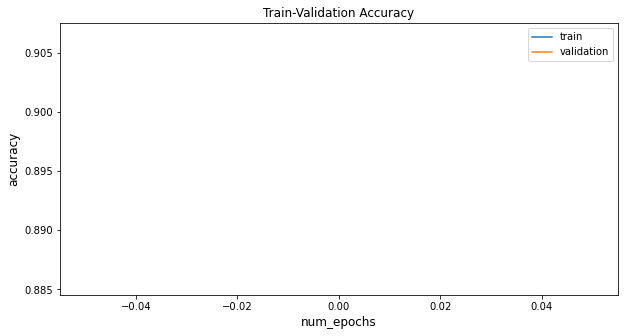

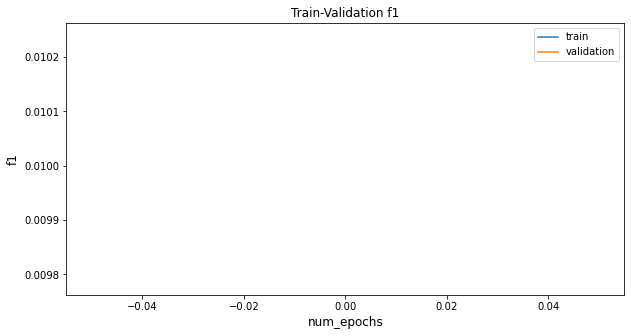

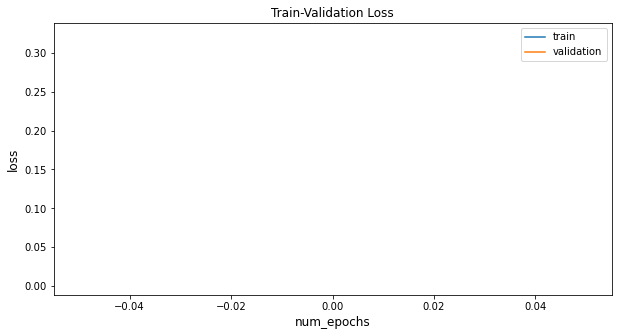

In [25]:
# val_loss = []
# val_f1_scores = []
# val_acc = []
# val_auc_scores = []

# train_loss = []
# train_f1_scores = []
# train_acc = []
# train_auc_scores = []

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation f1")
plt.plot(train_f1_scores, label='train')
plt.plot(val_f1_scores, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('f1', fontsize=12)
plt.legend(loc='best')


fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

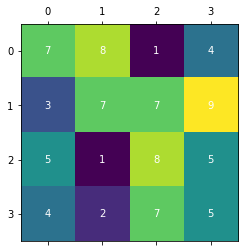

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a random confusion matrix
cm = np.random.randint(10, size=(4, 4))

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.matshow(cm)

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='white')

plt.show()

In [29]:
import seaborn as sns
def get_confusion_matrix(model, dataloader, saving_dir):    
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu') 
    np.random.seed(31101995)
    torch.manual_seed(31101995)
    labels = ['healthy', 'HGG','LGG']
    label_dict ={'0':'healthy', '1':'HGG','2':'LGG'}
    y_pred_list = []
    y_true_list = []    
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_test_pred = model(x_batch)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
                        
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())      
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    
    print("Pred: ",len(y_pred_list))
    print("True: ",len(y_true_list))
    print(classification_report(y_true_list, y_pred_list))
    classification_report_df = pd.DataFrame(classification_report(y_true_list, y_pred_list, output_dict=True))
    classification_report_df.rename(columns=label_dict, inplace=True)

#     classification_report_df =classification_report_df(index= labels)
    print(confusion_matrix(y_true_list, y_pred_list))
#     label_dict ={'healthy':0, 'HGG':1,'LGG':2}
#     labels = ['healthy', 'HGG','LGG']
    cm = confusion_matrix(y_true_list, y_pred_list)
#     cm = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list),index=labels)
#     print(cm)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    # Add numbers to the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='white')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(saving_dir / 'confusion_matrix.png')
    plt.show()
#     plt.savefig(saving_dir / 'confusion_matrix_heatmap.png')

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list),index=labels)
    confusion_matrix_df.tocsv( saving_dir / 'confusion_matrix_df.csv',index=False )
#     fig, ax = plt.subplots(figsize=(4,4)) 
#     plt.figure(figsize=(5,5))
#     sns_confusion_matrix = sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
#     # sns_confusion_matrix.savefig(saving_dir / 'sns_confusion_matrix.png', dpi=4000)
#     figure =  sns_confusion_matrix.get_figure()
#     figure.tight_layout()
#     figure.savefig(saving_dir / 'confusion_matrix.png', dpi=4000)
    return confusion_matrix_df, classification_report_df

Pred:  80
True:  80
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.81      1.00      0.89        29
           2       0.00      0.00      0.00         7

    accuracy                           0.91        80
   macro avg       0.60      0.67      0.63        80
weighted avg       0.84      0.91      0.87        80

[[44  0  0]
 [ 0 29  0]
 [ 0  7  0]]


/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

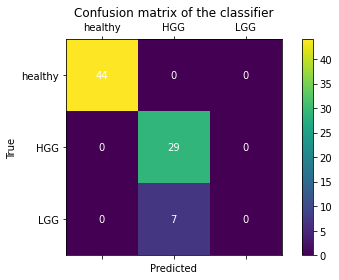

In [30]:
confusion_matrix_val_df, classification_report_val_df =get_confusion_matrix(model.eval(),
                                                                        val_dataloader, saving_dir=None)

In [221]:
classification_report_val_df

,healthy,HGG,LGG,accuracy,macro avg,weighted avg
precision,1.0,0.805556,0.0,0.9125,0.601852,0.842014
recall,1.0,1.000000,0.0,0.9125,0.666667,0.912500
f1-score,1.0,0.892308,0.0,0.9125,0.630769,0.873462
support,44.0,29.000000,7.0,0.9125,80.000000,80.000000


In [184]:
classification_report_val_df

,healthy,HGG,LGG,accuracy,macro avg,weighted avg
precision,1.0,0.878788,1.000000,0.95,0.959596,0.956061
recall,1.0,1.000000,0.428571,0.95,0.809524,0.950000
f1-score,1.0,0.935484,0.600000,0.95,0.845161,0.941613
support,44.0,29.000000,7.000000,0.95,80.000000,80.000000


In [181]:
classification_report_val_df

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,0.878788,1.000000,0.95,0.959596,0.956061
recall,1.0,1.000000,0.428571,0.95,0.809524,0.950000
f1-score,1.0,0.935484,0.600000,0.95,0.845161,0.941613
support,44.0,29.000000,7.000000,0.95,80.000000,80.000000


In [31]:
confusion_matrix_test_df =get_confusion_matrix(model.eval(), test_dataloader, saving_dir=None)

KeyboardInterrupt: 

Pred:  318
True:  318
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       166
           1       0.81      1.00      0.89       124
           2       0.00      0.00      0.00        28

    accuracy                           0.91       318
   macro avg       0.60      0.66      0.63       318
weighted avg       0.84      0.91      0.87       318

[[164   2   0]
 [  0 124   0]
 [  0  28   0]]


/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shsingh/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

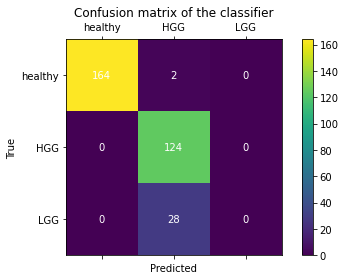

In [32]:
confusion_matrix_test_df, classification_report_test_df =get_confusion_matrix(model.eval(),
                                                                        test_dataloader, saving_dir=None)

In [ ]:
confusion_matrix_test_df

## old working training

In [27]:
print_every = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in tqdm(range(n_epochs)):
# range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    # lr_scheduler.step()
    print(f'Epoch {epoch}\n')
    print('LR:', lr_scheduler.get_last_lr())
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        target_ = target_.squeeze_().to(device)
        optimizer.zero_grad()
        #Forward pass
        outputs = model(data_)
        # print("outs: ",np.shape(outputs))
        # print("Targets: ",np.shape(target_))
        loss = criterion(outputs, target_)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # Calculate metrics
        f1, auc = calculate_metrics(outputs, target_)
        
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, 
                                                                       n_epochs,
                                                                       batch_idx, 
                                                                       total_step, loss.item()))

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.squeeze_().to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        if network_learned:
            valid_loss_min = batch_loss
#             model_saving_dir = Path(saving_dir)
#             torch.save(model.state_dict(), model_saving_dir / 'resnet18_base.pt')
            print('Improvement-Detected, save-model')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0

LR: [0.0001]
Epoch [0/5], Step [0/3], Loss: 1.0783


 20%|██        | 1/5 [00:00<00:02,  1.56it/s]


train-loss: 0.8611, train-acc: 66.0131
validation loss: 0.4048, validation acc: 93.5484

Improvement-Detected, save-model
Epoch 1

LR: [0.0001]
Epoch [1/5], Step [0/3], Loss: 0.5319


 40%|████      | 2/5 [00:01<00:01,  1.69it/s]


train-loss: 0.6091, train-acc: 90.1961
validation loss: 0.3348, validation acc: 93.5484

Improvement-Detected, save-model
Epoch 2

LR: [5e-05]
Epoch [2/5], Step [0/3], Loss: 0.1657


 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]


train-loss: 0.4816, train-acc: 89.5425
validation loss: 0.3114, validation acc: 93.5484

Improvement-Detected, save-model
Epoch 3

LR: [5e-05]
Epoch [3/5], Step [0/3], Loss: 0.2373


 80%|████████  | 4/5 [00:02<00:00,  1.77it/s]


train-loss: 0.4132, train-acc: 90.1961
validation loss: 0.2981, validation acc: 93.5484

Improvement-Detected, save-model
Epoch 4

LR: [2.5e-05]
Epoch [4/5], Step [0/3], Loss: 0.1743


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


train-loss: 0.3749, train-acc: 90.1961
validation loss: 0.2897, validation acc: 93.5484

Improvement-Detected, save-model


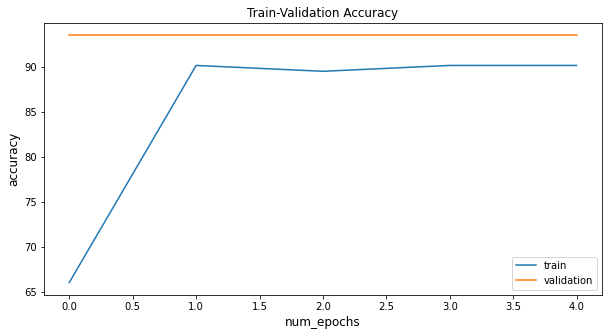

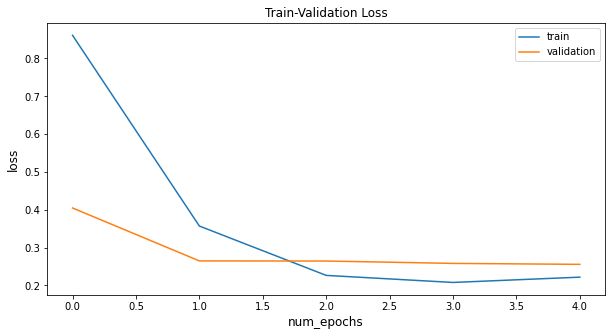

In [28]:
val_loss = []
val_f1_scores = []
val_acc = []
val_auc_scores = []

train_loss = []
train_f1_scores = []
train_acc = []
train_auc_scores = []

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')


fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

# working old code

In [18]:
print_every = 5

valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []

total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    lr_scheduler.step()
    
    print(f'Epoch {epoch}\n')
    print('LR:', lr_scheduler.get_lr())
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_= data_.to(device), target_.to(torch.int64)
        target_ = target_.squeeze_().to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
#         outputs = torch.argmax(outputs ,axis=1)
        outputs.to(torch.float32)
        
#         print(outputs)
#         print("outs: ",np.shape(outputs))
#         print("Targets: ",np.shape(target_))
        loss = criterion(outputs, target_)
#         print("LOSS: ",loss)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(torch.int64)
            
            target_t = target_t.squeeze_().to(device)
            
            
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'val_loss', 'train_acc',
                                'val_acc'
                            ])

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save({'epoch': n_epochs,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr': lr_scheduler.state_dict(),
                        'loss': loss }
                       ,'models/resnet18_npy_t1_35ep.pt')
            
            print('Improvement-Detected, save-model')
    model.train()
    

/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1

LR: [0.0001]
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: float32
dtype: int64
AFTER dtype: 

RuntimeError: GET was unable to find an engine to execute this computation

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')


fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

# SCRAP

In [6]:
from torchvision import models
import torch
 
# print(dir(models))
model = models.resnet18(pretrained=False)

/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
os.environ['HTTP_PROXY'] = 'http://fp:3210/'
os.environ['HTTPS_PROXY'] = 'https://fp:3210/'

In [6]:
!wget https://repos.anaconda.conda/miniconda/Miniconda3-latest-Linux-x86_64.sh

--2023-04-04 16:35:08--  https://repos.anaconda.conda/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving fp.cs.ovgu.de (fp.cs.ovgu.de)... 141.44.34.54
Connecting to fp.cs.ovgu.de (fp.cs.ovgu.de)|141.44.34.54|:3210... connected.
Proxy tunneling failed: Service UnavailableUnable to establish SSL connection.


In [7]:
!wget https://repo.anaconda.com/archive/Anaconda3-2023.03-Linux-x86_64.sh

--2023-04-04 16:36:29--  https://repo.anaconda.com/archive/Anaconda3-2023.03-Linux-x86_64.sh
Resolving fp.cs.ovgu.de (fp.cs.ovgu.de)... 141.44.34.54
Connecting to fp.cs.ovgu.de (fp.cs.ovgu.de)|141.44.34.54|:3210... connected.
Proxy request sent, awaiting response... 200 OK
Length: 901858012 (860M) [application/x-sh]
Saving to: ‘Anaconda3-2023.03-Linux-x86_64.sh’

Anaconda3-2023.03-L 100%[===================>] 860.08M   155MB/s    in 5.9s    

2023-04-04 16:36:35 (146 MB/s) - ‘Anaconda3-2023.03-Linux-x86_64.sh’ saved [901858012/901858012]



In [8]:
!pwd


/project/shsingh/knowledge_distillation/notebooks


In [5]:
from torchvision import models
import torch
 
# print(dir(models))
model = models.resnet18(pretrained=True)

/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s] 


In [7]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

    
# model_urls = {
#     'resnet18': 'https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://s3.amazonaws.com/pytorchg/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://s3.amazonaws.com/pytorch/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://s3.amazonaws.com/pytorch/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://s3.amazonaws.com/pytorch/models/resnet152-b121ed2d.pth',
#     'resnext50_32x4d': 'https://s3.amazonaws.com/pytorch/models/resnext50_32x4d-7cdf4587.pth',
#     'resnext101_32x8d': 'https://s3.amazonaws.com/pytorch/models/resnext101_32x8d-8ba56ff5.pth',
#     'wide_resnet50_2': 'https://s3.amazonaws.com/pytorch/models/wide_resnet50_2-95faca4d.pth',
#     'wide_resnet101_2': 'https://s3.amazonaws.com/pytorch/models/wide_resnet101_2-32ee1156.pth',
# }


In [3]:
!wget https://download.pytorch.org/models/resnet18-5c106cde.pth

--2023-03-16 21:50:20--  https://download.pytorch.org/models/resnet18-5c106cde.pth
Resolving fp.cs.ovgu.de (fp.cs.ovgu.de)... 141.44.34.54
Connecting to fp.cs.ovgu.de (fp.cs.ovgu.de)|141.44.34.54|:3210... connected.
Proxy request sent, awaiting response... 200 OK
Length: 46827520 (45M) [application/octet-stream]
Saving to: ‘resnet18-5c106cde.pth’

resnet18-5c106cde.p 100%[===================>]  44.66M  96.6MB/s    in 0.5s    

2023-03-16 21:50:20 (96.6 MB/s) - ‘resnet18-5c106cde.pth’ saved [46827520/46827520]



In [6]:
mv resnet18-5c106cde.pth /home/shsingh/.cache/torch/hub/checkpoints

In [4]:
resnet = torchvision.models.resnet18(weights = "ResNet18_Weights.IMAGENET1K_V1")

Downloading: "http://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [115]:
from torchvision.models.resnet18 import model_urls

model_urls['resnet18'] = model_urls['resnet18'].replace('https://', 'http://')
resnet18 = torchvision.models.resnet18(pretrained=True)

ModuleNotFoundError: No module named 'torchvision.models.resnet18'

In [121]:
os.environ['TORCH_HOME'] = 'models/resnet' #setting the environment variable
resnet = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to models/resnet/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [6]:
model = model_zoo.load_url(model_urls['resnet50'], model_dir='~/.torch/') )

URLError: <urlopen error [Errno 111] Connection refused>

# Draft

In [ ]:
arr_li =[]
lbl_li =[]
train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)     
for images, labels in train_dataloader:
    arr_li.append(images)
    lbl_li.apppend(labels)

In [15]:
batch_size = 64
train_data = CustomImageDataset_from_csv(train_df , 't1',
           transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

val_data = CustomImageDataset_from_csv(val_df , 't1',
         transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))


test_data = CustomImageDataset_from_csv(test_df , 't1',
          transform=transforms.Compose([
                                   transforms.ToTensor()                    
                               ]))

In [16]:
print("Shape of trainig data :",train_data.dataframe.shape)
print("Shape of validation data :",val_data.dataframe.shape)
print("Shape of test data :",test_data.dataframe.shape)

Shape of trainig data : (35583, 11)
Shape of validation data : (5119, 11)
Shape of test data : (10197, 11)


In [17]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)

test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

In [19]:
arr_li =[]
lbl_li =[]   
for images, labels in train_dataloader:
    arr_li.append(images)
    lbl_li.append(labels)
    print(labels)
    break

healthy
healthy
healthy
healthy
healthy
HGG
healthy
healthy
healthy
healthy
HGG
healthy
healthy
HGG
healthy
healthy
HGG
healthy
HGG
HGG
healthy
healthy
HGG
healthy
LGG
HGG
HGG
HGG
HGG
healthy
HGG
healthy
HGG
healthy
healthy
healthy
healthy
HGG
LGG
HGG
HGG
healthy
healthy
healthy
HGG
healthy
HGG
LGG
healthy
healthy
healthy
HGG
healthy
HGG
healthy
healthy
healthy
HGG
healthy
HGG
LGG
HGG
healthy
LGG
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [2],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
  

TypeError: 'int' object is not iterable

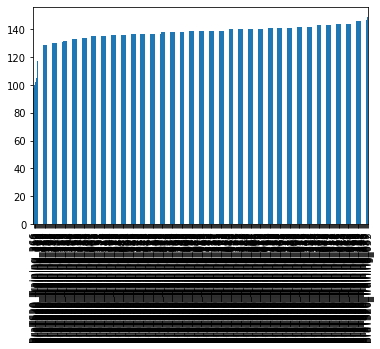

In [25]:
all_data.subject_id.value_counts().sort_values().plot(kind='bar') 
plt.xticks(np.arange(min(0), max(369)+1, 100))
plt.xticks(rotation=60)

In [13]:
df  = pd.read_csv("/home/shsingh/knowledge_distillation/dataset/scratch/meta_data_survival_mapping.csv")

In [14]:
df.head()

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR


In [16]:
df['image_path'][0] 

'/home/shsingh/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_seg/BraTS20_Training_001_seg_0.npy'

In [7]:
df['image_path'][0].split('')

'/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_seg/BraTS20_Training_001_seg_0.npy'

In [9]:
def update_lrx_denoise_path_single(x, mode="add"):

    return x.replace("/knowledge_distillation/knowledge_distillation/", "/knowledge_distillation/")





In [10]:
df["image_path"] = df["image_path"].apply(update_lrx_denoise_path_single)

df[['image_path']]
#  df.to_csv(path, sep='|', )

,image_path
0,/home/shsingh/knowledge_distillation/dataset/s...
1,/home/shsingh/knowledge_distillation/dataset/s...
2,/home/shsingh/knowledge_distillation/dataset/s...
3,/home/shsingh/knowledge_distillation/dataset/s...
4,/home/shsingh/knowledge_distillation/dataset/s...
...,...
57190,/home/shsingh/knowledge_distillation/dataset/s...
57191,/home/shsingh/knowledge_distillation/dataset/s...
57192,/home/shsingh/knowledge_distillation/dataset/s...
57193,/home/shsingh/knowledge_distillation/dataset/s...


In [12]:
df.to_csv("/home/shsingh/knowledge_distillation/dataset/scratch/meta_data_survival_mapping.csv", index=False)